<h1 style="text-align:center;font-size:60px"><u>Bioactivity prediction</u></h1>

<h1 style="text-align:center;font-size:20px">Name : Karthik Babu Nambiar<br>
Roll Number: 17120</h1>

__In this project we are trying to fit different models with the Chembl data for COVID-19 and find a model the predicts the bioactivity of molecules.__

## Contents

1. [Looking into the dataset](#Looking-into-the-dataset)


2. [Data Cleaning](#Data-Cleaning)


3. [Helper Functions](#Helper-Functions) 
    - [Splitting the data](#Splitting-the-data-into-train-data,-train-labels,-test-data-and-test-labels)
    - [Model score](#Model-Score)
    - [Plotting predictions of the train data vs true train labels](#Plotting-predictions-of-the-train-data-vs-true-train-labels)
    - [Plotting predictions of the test data vs true test labels](#Plotting-predictions-of-the-test-data-vs-true-test-labels)
    - [Learning curve](#Learning-curve)
    - [Compare Model Fitting](#Compare-Model-Fitting)


4. [Different Models](#Different-Models)
    - [Linear Regression with polynomial features without regularization](#Linear-Regression-with-polynomial-features-without-regularization)
    - [Linear Regression with polynomial features with regularization](#Linear-Regression-with-polynomial-features-with-regularization)
    - [Decision Tree Regression with polynomial features](#Decision-Tree-Regression-with-polynomial-features)
    - [Bayesian Regression](#Bayesian-Regression)
    

5. [Comparing Different Models](#Comparing-Different-Models)


6. [Conclusions](#Conclusions)

## Looking into the dataset

    Importing necessary libraries

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

    Reading the dataset downloaded from the Chembl website in .csv file format. 

In [127]:
chembl_data = pd.read_csv(r"dataset.csv", sep = ';')

    Looking into the number of features and number of data samples in the dataset.

In [128]:
print('Shape of the original dataset we are using : {} '.format(chembl_data.shape))
print('Number of data samples : {}'.format(chembl_data.shape[0]))
print('Number of features : {}'.format(chembl_data.shape[1]))


Shape of the original dataset we are using : (6900, 31) 
Number of data samples : 6900
Number of features : 31


    Identifying the features of the dataset.

In [129]:
chembl_data.columns

Index(['ChEMBL ID', 'Name', 'Synonyms', 'Type', 'Max Phase',
       'Molecular Weight', 'Targets', 'Bioactivities', 'AlogP', 'PSA', 'HBA',
       'HBD', '#RO5 Violations', '#Rotatable Bonds', 'Passes Ro3',
       'QED Weighted', 'CX ApKa', 'CX BpKa', 'CX LogP', 'CX LogD',
       'Aromatic Rings', 'Structure Type', 'Inorganic Flag', 'Heavy Atoms',
       'HBA Lipinski', 'HBD Lipinski', '#RO5 Violations (Lipinski)',
       'Molecular Weight (Monoisotopic)', 'Molecular Species',
       'Molecular Formula', 'Smiles'],
      dtype='object')

    Looking into first five samples of the dataset.

In [130]:
chembl_data.head()

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,PSA,...,Structure Type,Inorganic Flag,Heavy Atoms,HBA Lipinski,HBD Lipinski,#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles
0,CHEMBL35093,NaN,PD-172939,Small molecule,0,349.48,8,8,3.30,35.58,...,MOL,-1,26,4,1,0,349.2154,NEUTRAL,C22H27N3O,Cc1ccc(N2CCN(CC[C@H]3NC(=O)c4ccccc43)CC2)cc1C
1,CHEMBL3039407,NaN,NaN,Small molecule,0,454.97,1,1,3.89,72.83,...,MOL,-1,31,5,1,0,454.1922,NEUTRAL,C24H32ClFO5,CC1(C)O[C@@H]2CC3C4CCC5=CC(=O)CCC5(C)C4(F)C(O)...
2,CHEMBL394875,NaN,NaN,Small molecule,0,135.19,4,4,-0.24,63.32,...,MOL,-1,8,3,3,0,135.0354,ZWITTERION,C4H9NO2S,CSC[C@H](N)C(=O)O
3,CHEMBL55743,NaN,NaN,Small molecule,0,207.23,4,5,0.82,66.40,...,MOL,-1,15,4,2,0,207.0895,ACID,C11H13NO3,CC(=O)N[C@@H](Cc1ccccc1)C(=O)O
4,CHEMBL200381,NaN,NaN,Small molecule,0,404.84,236,486,5.04,86.52,...,MOL,-1,29,6,2,1,404.0953,NEUTRAL,C21H14ClFN6,N#Cc1cnc2cnc(NCc3cccnc3)cc2c1Nc1ccc(F)c(Cl)c1


## Data Cleaning

    Checking whether the target column (Bioactivities) has any Nan values. If there are Nan values present in the target it should be remoived from the dataset before fitting the dataset in the model.

In [131]:
chembl_data['Bioactivities'].isna().sum() 

0

    Dropping unwanted features before fitting the model.

In [132]:
data = chembl_data.copy(deep = True)
data = data.drop(["ChEMBL ID", 'Name', 'Synonyms', 'Type', 'Max Phase', '#RO5 Violations','Passes Ro3', 'Structure Type', 
                  'Inorganic Flag', '#RO5 Violations (Lipinski)', 'Molecular Species', 'Molecular Formula', 'Smiles',  
                  'CX ApKa', 'CX BpKa'], axis = 1)

    Finding the mean molecular weight of the molecules.

In [133]:
data['Molecular Weight'].mean() 

387.75888516955297

    Dropping data samples where the bioactivity is less than 500.<br>
    Also dropping all data samples where any of the feature values is not present.

In [134]:
data = data[data['Molecular Weight'] < 500] 
data = data[data['AlogP'] != 'None'] 

    There is one outlier in the dataset so removing it before fitting the data.

In [135]:
maximum = data["Bioactivities"].max()
data = data.drop(data[data["Bioactivities"] == maximum].index, axis = 0)

    Looking into the data after data cleaning.

In [136]:
data.head()

,Molecular Weight,Targets,Bioactivities,AlogP,PSA,HBA,HBD,#Rotatable Bonds,QED Weighted,CX LogP,CX LogD,Aromatic Rings,Heavy Atoms,HBA Lipinski,HBD Lipinski,Molecular Weight (Monoisotopic)
0,349.48,8,8,3.30,35.58,3,1,4,0.92,3.70,2.99,2,26,4,1,349.2154
1,454.97,1,1,3.89,72.83,5,1,2,0.64,3.30,3.30,0,31,5,1,454.1922
2,135.19,4,4,-0.24,63.32,3,2,3,0.56,-2.40,-2.41,0,8,3,3,135.0354
3,207.23,4,5,0.82,66.40,2,2,4,0.77,0.90,-2.25,1,15,4,2,207.0895
4,404.84,236,486,5.04,86.52,6,2,5,0.48,3.53,3.53,4,29,6,2,404.0953


    Shape of the data after data cleaning.

In [137]:
print('Shape of data after data cleaning : {}'.format(data.shape))

Shape of data after data cleaning : (5655, 16)


## Helper Functions

#### Splitting the data into train data, train labels, test data and test labels
    This function also creates polynomial features of the data.

In [138]:
def split(test_size = 0.2, poly_degree = 1):
    poly = PolynomialFeatures(degree = poly_degree)
    data_poly = data.drop('Bioactivities', axis = 1)
    data_poly = pd.DataFrame(poly.fit_transform(data_poly))
    X_train, X_test, y_train, y_test = train_test_split(data_poly, data['Bioactivities'], 
                                                        test_size = test_size, random_state = 42)
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train))
    X_test = pd.DataFrame(scaler.transform(X_test))
    
    result = {
        'X_train' : X_train,
        'y_train' : y_train,
        'X_test' : X_test,
        'y_test' : y_test,
    }
    return result


#### Model Score
    The metric used here is Root Mean Squared Error. 
    This function will output the RMSE of train data, test data and also the mean of 5-fold cross validation score of train data

In [139]:
def model_score(model,data):
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    cross_score = -1 * cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error', cv = 5)
    
    train_set = np.sqrt(mean_squared_error(model.predict(X_train), y_train))
    test_set = np.sqrt(mean_squared_error(model.predict(X_test), y_test))
    cross_val_score_mean = np.sqrt(cross_score).mean()
    
    score = {
            'train_set': train_set,
            'test_set': test_set,
            'cross_val_score': cross_val_score_mean
    }
                                 
                                 
    return score

#### Plotting predictions of the train data vs true train labels

In [140]:
def plot_train_prediction(model,data):
    y_pred = model.predict(data['X_train'])
    y_train = data['y_train']
    x_ = np.linspace(0,7000, 100)
    y = x_
    fig = plt.gcf()
    plt.scatter(y_train, y_pred, edgecolors=(0, 0, 0), label = 'data')
    plt.plot(y, x_ ,'orange', label = 'correct line')
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.legend()
    return fig

#### Plotting predictions of the test data vs true test labels

In [141]:
def plot_test_prediction(model,data):
    y_pred = model.predict(data['X_test'])
    y_train = data['y_test']
    x_ = np.linspace(0,7000, 100)
    y = x_
    fig = plt.gcf()
    plt.scatter(y_train, y_pred,edgecolors=(0, 0, 0), label = 'data')
    plt.plot(y, x_ ,'orange', label = 'correct line')
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.legend()
    return fig

#### Learning curve
    Learning curves shows the errors in training data and cross validation set when the model is trained on different numbers of data samples.

In [142]:
def plot_learning_curve(model, data):
    fig = plt.gcf()
    train_sizes, train_scores_svr, test_scores_svr = learning_curve(model,data['X_train'],data['y_train'], train_sizes=np.linspace(0.1, 1, 20),
                   scoring="neg_mean_squared_error", cv = 5)
    plt.plot(train_sizes, np.sqrt(-test_scores_svr).mean(1), 'o-', color="r",
             label="cross validation score")
    plt.plot(train_sizes, np.sqrt(-train_scores_svr).mean(1), 'o-', color="g",
             label="train score")
    plt.xlabel("Train size")
    plt.ylabel("Root Mean Squared Error")
    plt.title('Learning curves')
    plt.legend(loc="best")
    return fig

#### Compare Model Fitting
    Plots the train predictions, test predictions and the learning curve of the model together fitted to upto a max_degree of polynomial features.

    Helps in comparing different model with different degree of polynomial features and determine whether the model is overfitting or underfitting

In [19]:
def plot(model_name  ,max_degree):
    index = [i*3 for i in range(max_degree)]
    fig = plt.gcf()
    fig.set_size_inches(18,(max_degree/3)*18)
    for i,j in enumerate(index):
        plt.subplot(max_degree,3,j+1)
        plot_train_prediction(model[model_name]['degree {}'.format(i+1)],
                                                     dataset['degree {}'.format(i+1)])
        plt.title('Train Prediction (Degree = {})'.format(i+1))
        plt.subplot(max_degree,3,j+2)
        plot_test_prediction(model[model_name]['degree {}'.format(i+1)],
                                                   dataset['degree {}'.format(i+1)])
        plt.title('Test Prediction (Degree = {})'.format(i+1))
        plt.subplot(max_degree,3,j+3)
        plot_learning_curve(model[model_name]['degree {}'.format(i+1)],
                                                   dataset['degree {}'.format(i+1)])
    plt.suptitle(model_name, fontsize = 20)
    plt.subplots_adjust(wspace = 0.4, hspace = 0.2, top = 1 - 1/((max_degree/3)*18))
    return plt.show()    

    Creating datasets of polynomial features upto 4 degrees.

In [20]:
dataset  = {}
for i in range(4):
    dataset['degree {}'.format(i+1)] = split(poly_degree = i+1)

In [21]:
model = {}
score = {}

## Different Models

### Linear Regression with polynomial features without regularization

In [22]:
def linear_model(result):
    X_train = result['X_train']
    X_test = result['X_test']
    y_train = result['y_train']
    y_test = result['y_test']
    reg = LinearRegression().fit(X_train,y_train)
    return reg
    

    Creating Linear regression models without regularization and fitting those models with polynomial features upto 4 degrees.

    So we have four models fitted with 4 degrees of polynomial features.

In [23]:
model['linear regression without regularization'] = {}
for i in range(4):
    model['linear regression without regularization']['degree {}'.format(i+1)] = linear_model(dataset['degree {}'.format(i+1)])

    Extracting the train, test, and cross validation scores of the models.

In [24]:
score['linear regression without regularization'] = {}
for i in range(4):
    score['linear regression without regularization']['degree {}'.format(i+1)] = model_score(model['linear regression without regularization']['degree {}'.format(i+1)],
                                                                                                                 dataset['degree {}'.format(i+1)])

    Plotting different models for comparison.

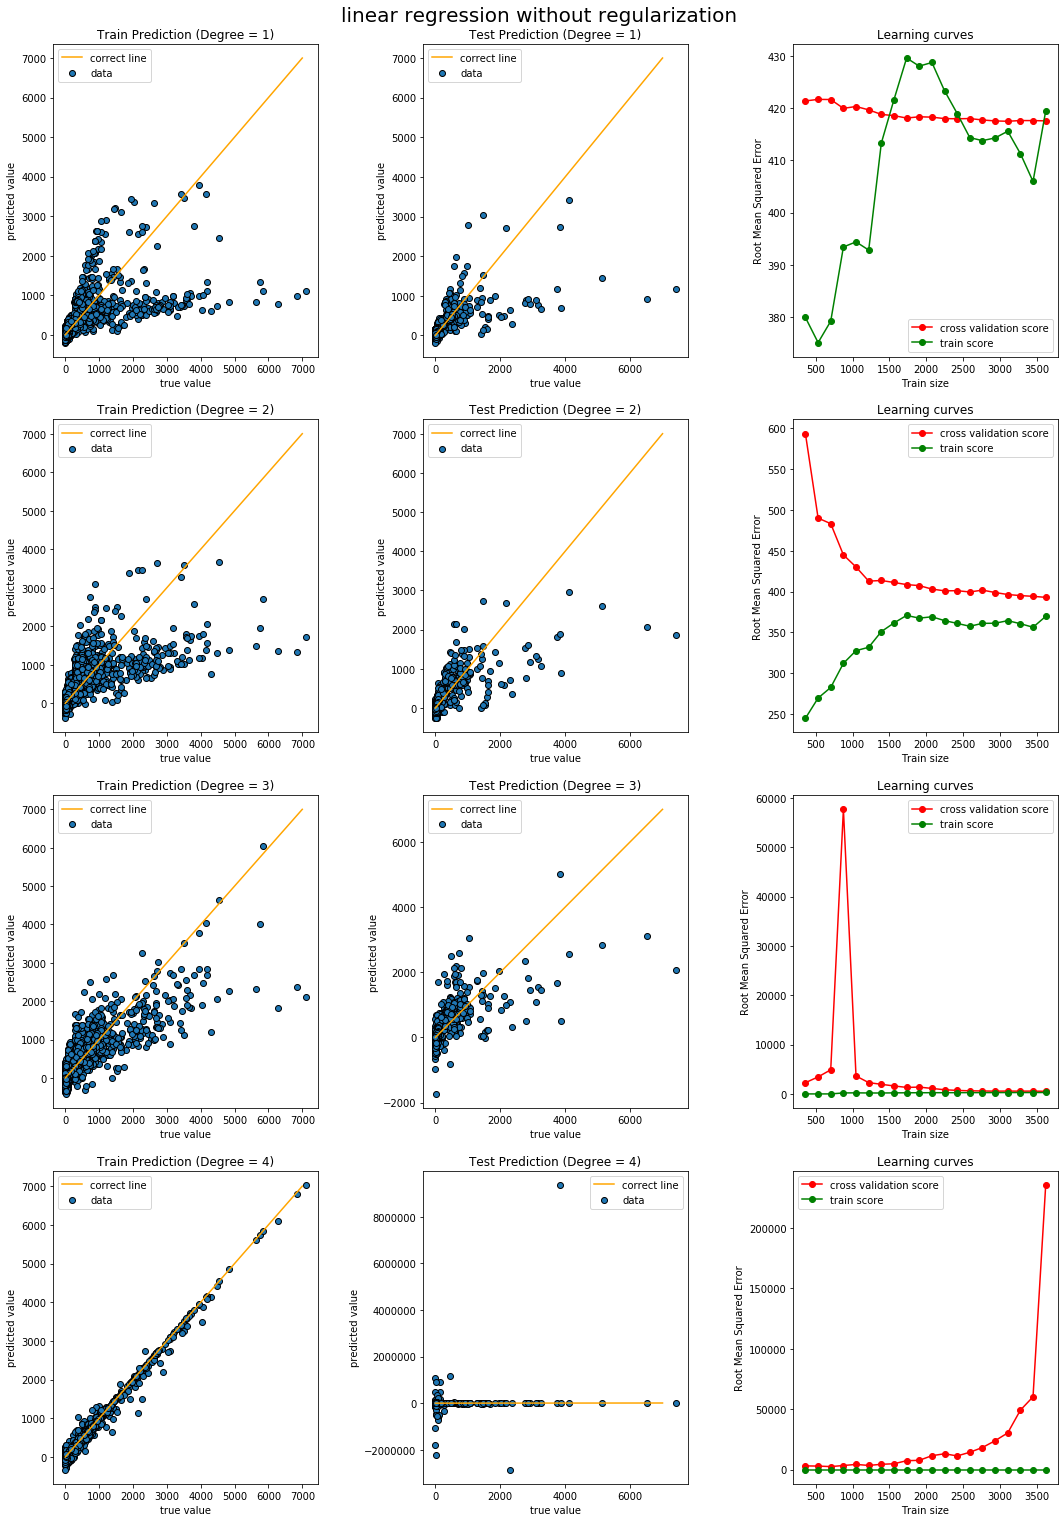

In [25]:
plot(model_name = 'linear regression without regularization',max_degree = 4)

    Comparing the scores of different models.

In [26]:
linear_reg = pd.DataFrame(score['linear regression without regularization'])
linear_reg

,degree 1,degree 2,degree 3,degree 4
train_set,419.866307,372.359705,302.323809,73.435118
test_set,418.615324,373.617408,408.804532,315326.589993
cross_val_score,417.576640,392.908943,530.672084,234891.759073


### Linear Regression with polynomial features with regularization

In [27]:
def ridge_model(result):
    X_train = result['X_train']
    X_test = result['X_test']
    y_train = result['y_train']
    y_test = result['y_test']
    ridge = Ridge(alpha = 1).fit(X_train,y_train)
    return ridge
    

    Creating Linear regression models with regularization and fitting those models with polynomial features upto 4 degrees.

    So we have four models fitted with 4 degrees of polynomial features.

In [28]:
model['linear regression with regularization'] = {}
for i in range(4):
    model['linear regression with regularization']['degree {}'.format(i+1)] = ridge_model(dataset['degree {}'.format(i+1)])

    Extracting the train, test, and cross validation scores of the models.

In [29]:
score['linear regression with regularization'] = {}
for i in range(4):
    score['linear regression with regularization']['degree {}'.format(i+1)] = model_score(model['linear regression with regularization']['degree {}'.format(i+1)],
                                                                                          dataset['degree {}'.format(i+1)])

    Plotting different models for comparison.

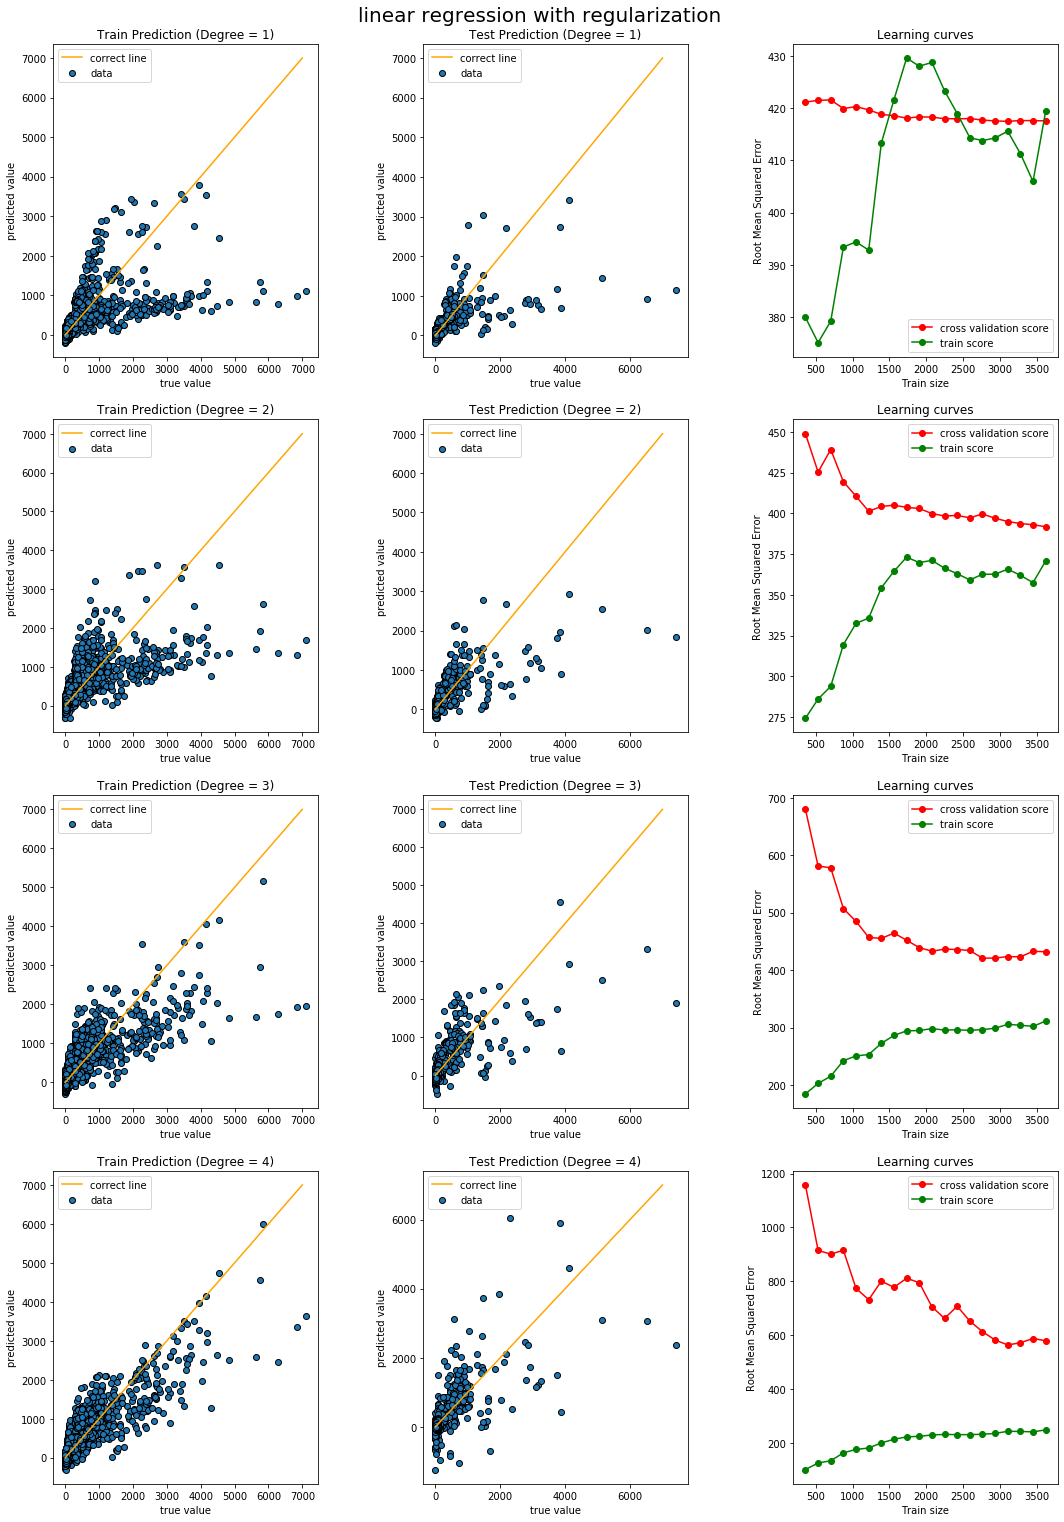

In [30]:
plot(model_name = 'linear regression with regularization',max_degree = 4)

    Comparing the scores of different models.

In [31]:
ridge_reg = pd.DataFrame(score['linear regression with regularization'])
ridge_reg

,degree 1,degree 2,degree 3,degree 4
train_set,419.866345,373.331604,319.505548,259.533636
test_set,418.620364,374.237336,371.551272,419.349684
cross_val_score,417.572391,391.771967,431.990171,579.059199


## Decision Tree Regression with polynomial features

In [32]:
def decision_tree_model(result):
    X_train = result['X_train']
    X_test = result['X_test']
    y_train = result['y_train']
    y_test = result['y_test']
    decision_tree = DecisionTreeRegressor().fit(X_train,y_train)
    return decision_tree

    Creating Decision tree models and fitting those models with polynomial features upto 4 degrees.

    So we have four models fitted with 4 degrees of polynomial features.

In [33]:
model['decision tree'] = {}
for i in range(4):
    model['decision tree']['degree {}'.format(i+1)] = decision_tree_model(dataset['degree {}'.format(i+1)])

    Extracting the train, test, and cross validation scores of the models.

In [34]:
score['decision tree'] = {}
for i in range(4):
    score['decision tree']['degree {}'.format(i+1)] = model_score(model['decision tree']['degree {}'.format(i+1)],
                                                                  dataset['degree {}'.format(i+1)])

    Plotting different models for comparison.

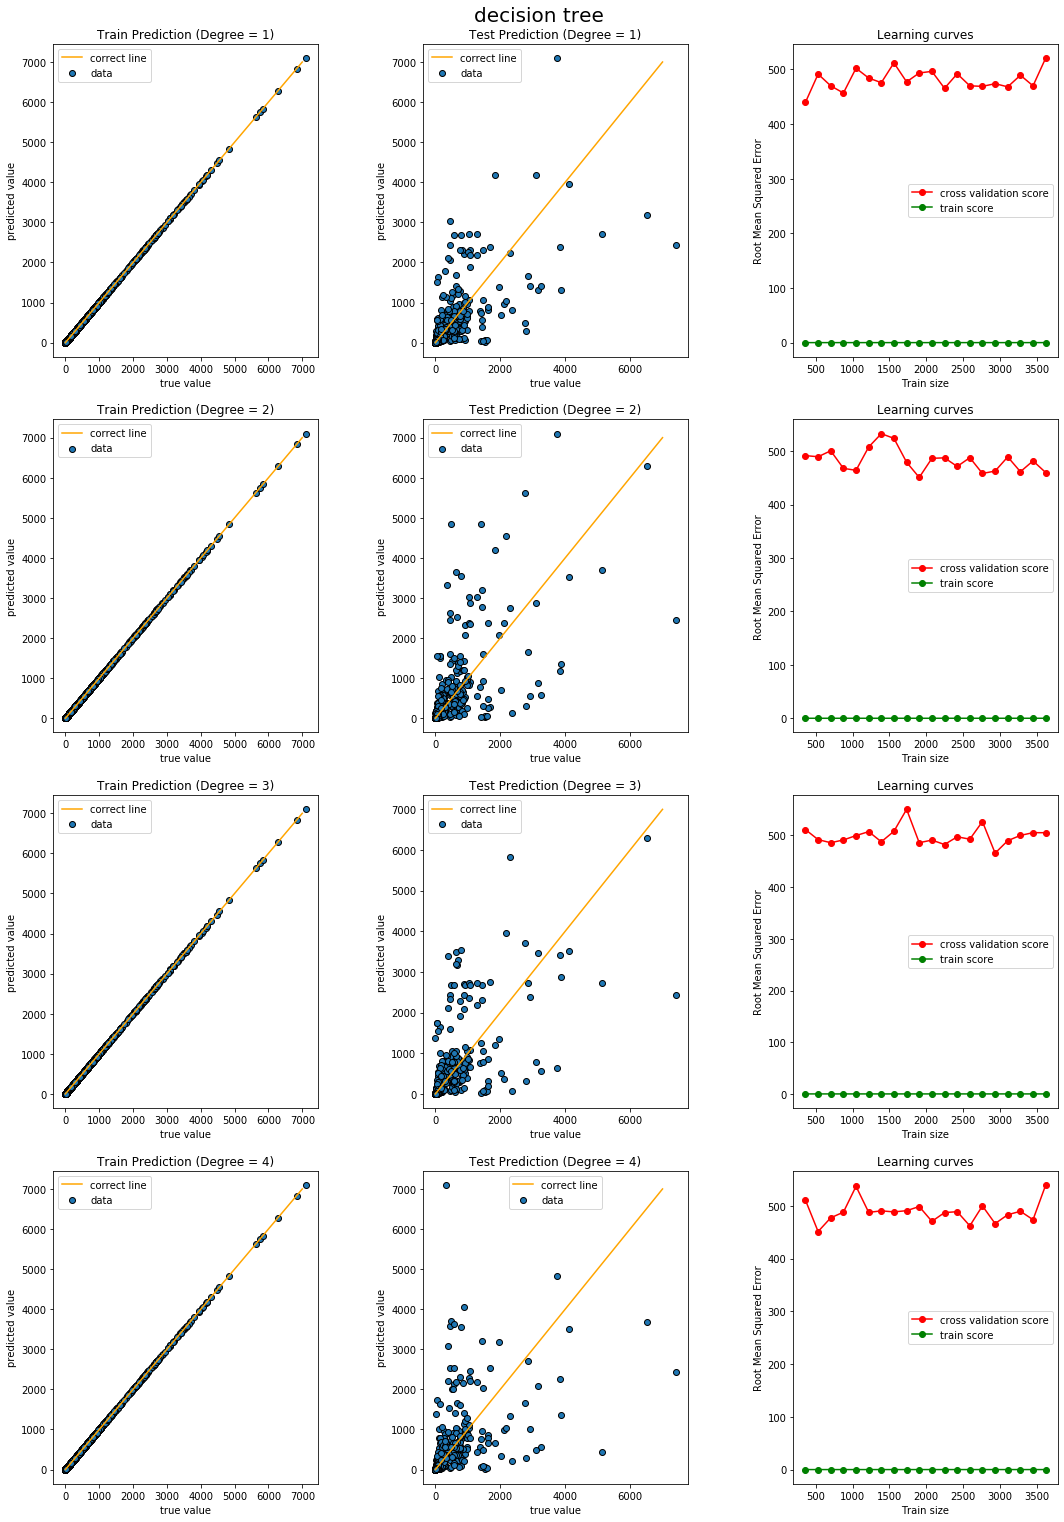

In [35]:
plot(model_name = 'decision tree',max_degree = 4)

    Comparing the scores of different models.

In [36]:
decision_tree = pd.DataFrame(score['decision tree'])
decision_tree

,degree 1,degree 2,degree 3,degree 4
train_set,0.010513,0.010513,0.010513,0.010513
test_set,402.316586,460.950956,445.487777,499.054130
cross_val_score,515.481392,463.807661,491.780578,529.658289


## Bayesian Regression

In [37]:
def bayesian_reg_model(result):
    X_train = result['X_train']
    X_test = result['X_test']
    y_train = result['y_train']
    y_test = result['y_test']
    bayesian_regression = BayesianRidge().fit(X_train,y_train)
    return bayesian_regression

    Creating Bayesian regression models and fitting those models with polynomial features upto 4 degrees.

    So we have four models fitted with 4 degrees of polynomial features.

In [38]:
model['bayesian regression'] = {}
for i in range(4):
    model['bayesian regression']['degree {}'.format(i+1)] = bayesian_reg_model(dataset['degree {}'.format(i+1)])

    Extracting the train, test, and cross validation scores of the models.

In [39]:
score['bayesian regression'] = {}
for i in range(4):
    score['bayesian regression']['degree {}'.format(i+1)] = model_score(model['bayesian regression']['degree {}'.format(i+1)],
                                                                  dataset['degree {}'.format(i+1)])

    Plotting different models for comparison.

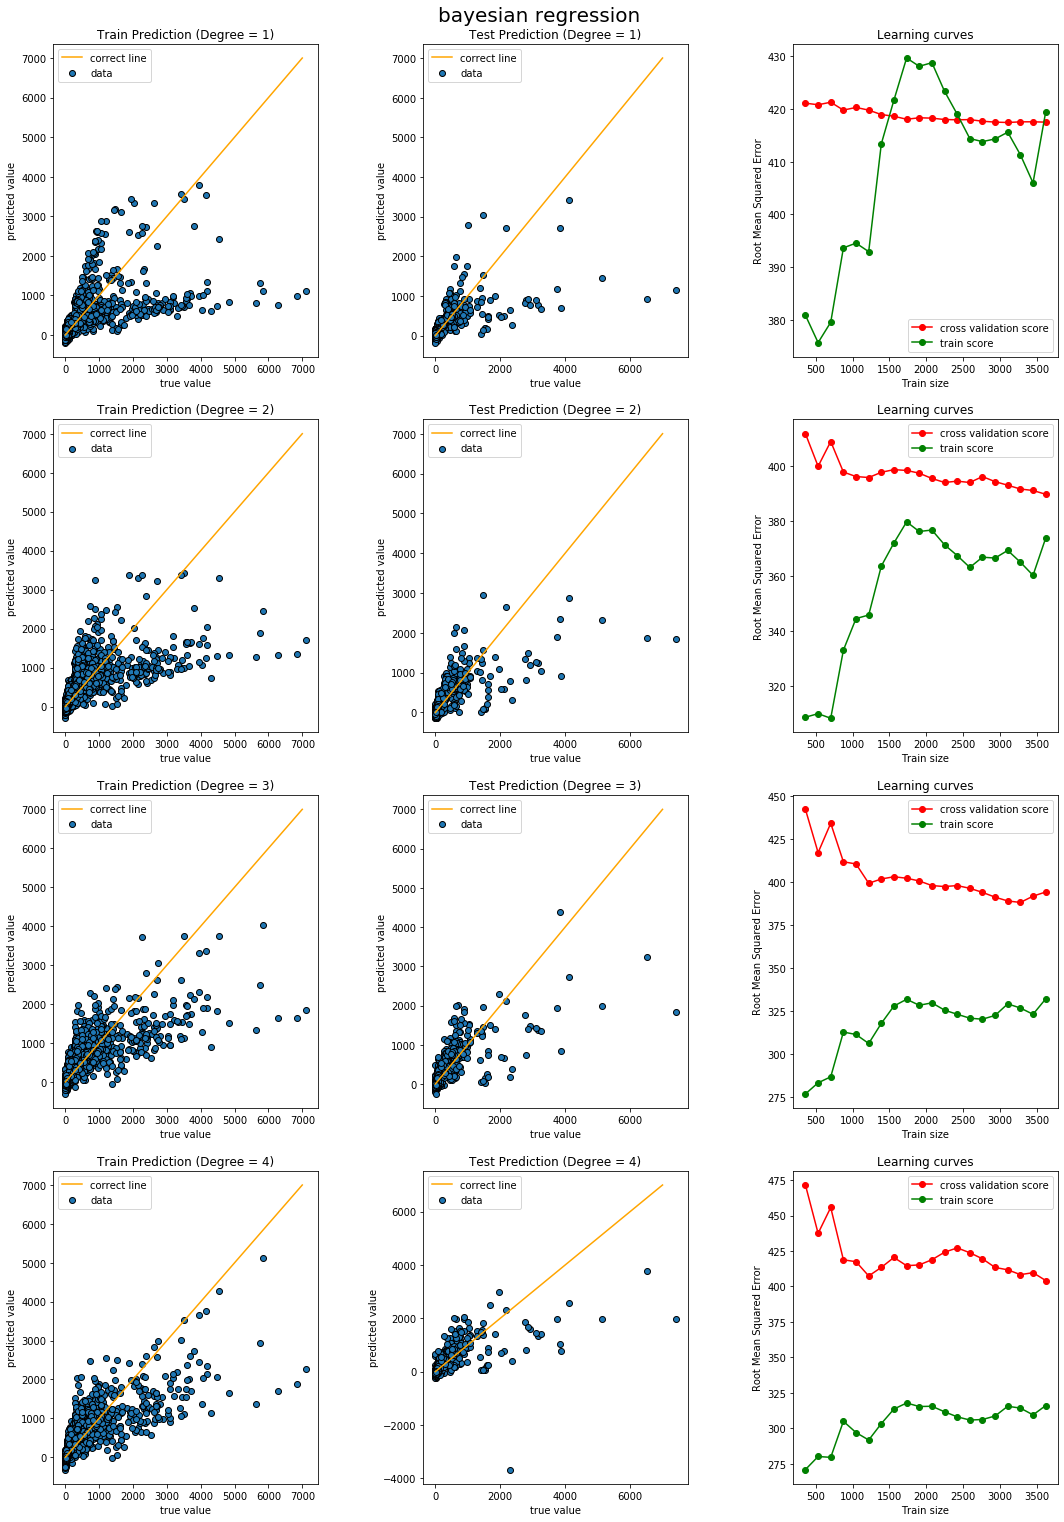

In [40]:
plot(model_name = 'bayesian regression',max_degree = 4)

    Comparing the scores of different models.

In [41]:
bayesian_reg = pd.DataFrame(score['bayesian regression'])
bayesian_reg

,degree 1,degree 2,degree 3,degree 4
train_set,419.876959,375.652153,337.025040,320.420003
test_set,418.721758,372.505208,362.046311,403.531846
cross_val_score,417.520349,389.671285,394.414341,404.180608


## Comparing Different Models

    Comparing scores of different models

In [102]:
performance = pd.DataFrame.from_dict({(i,j): score[i][j] 
                           for i in score.keys() 
                           for j in score[i].keys()},
                       orient='index').T

In [103]:
performance

linear regression without regularization              \
                                                degree 1    degree 2   
train_set                                     419.866307  372.359705   
test_set                                      418.615324  373.617408   
cross_val_score                               417.576640  392.908943   

                                            \
                   degree 3       degree 4   
train_set        302.323809      73.435118   
test_set         408.804532  315326.589993   
cross_val_score  530.672084  234891.759073   

                linear regression with regularization                          \
                                             degree 1    degree 2    degree 3   
train_set                                  419.866345  373.331604  319.505548   
test_set                                   418.620364  374.237336  371.551272   
cross_val_score                            417.572391  391.771967  431.990171   

                            decision tree                                      \
                   degree 4      degree 1    degree 2    degree 3    degree 4   
train_set        259.533636      0.010513    0.010513    0.010513    0.010513   
test_set         419.349684    402.316586  460.950956  445.487777  499.054130   
cross_val_score  579.059199    515.481392  463.807661  491.780578  529.658289   

                bayesian regression                                      
                           degree 1    degree 2    degree 3    degree 4  
train_set                419.876959  375.652153  337.025040  320.420003  
test_set                 418.721758  372.505208  362.046311  403.531846  
cross_val_score          417.520349  389.671285  394.414341  404.180608

    Bar Plot of Scores of Different Models

In [104]:
model_name = list(score.keys())

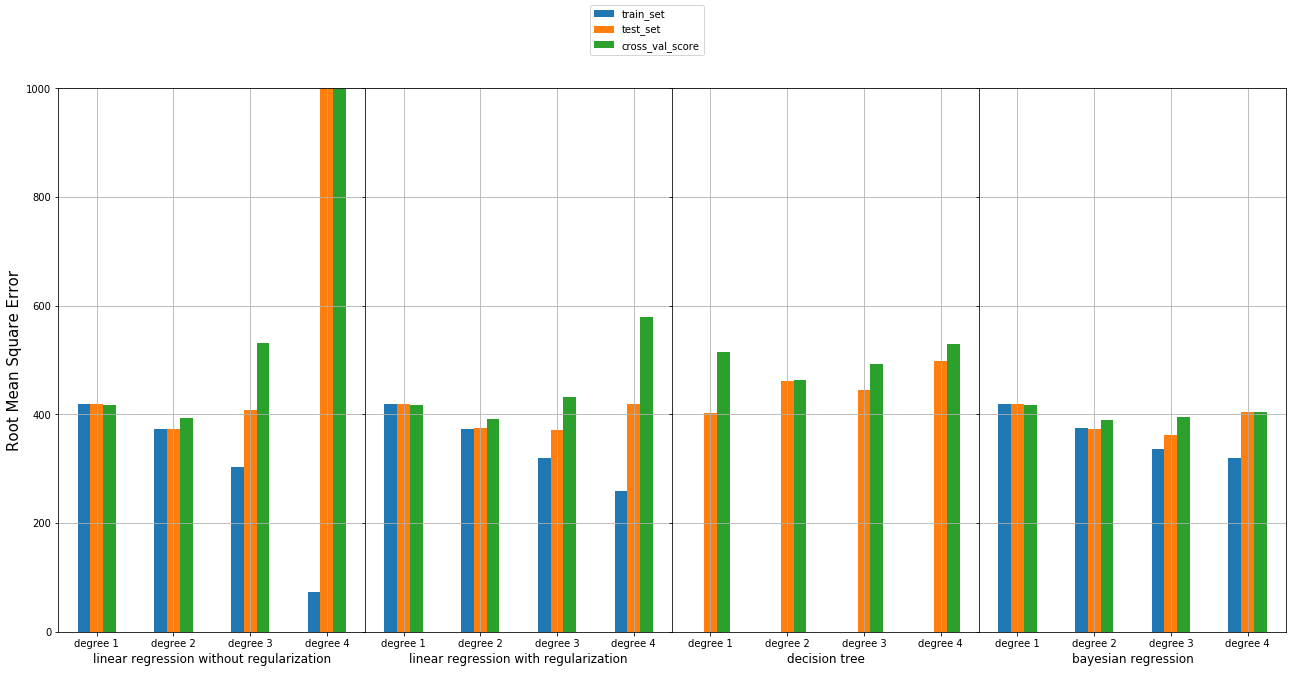

train_set       test_set  \
linear regression without regularization degree 1  419.866307     418.615324   
                                         degree 2  372.359705     373.617408   
                                         degree 3  302.323809     408.804532   
                                         degree 4   73.435118  315326.589993   
linear regression with regularization    degree 1  419.866345     418.620364   
                                         degree 2  373.331604     374.237336   
                                         degree 3  319.505548     371.551272   
                                         degree 4  259.533636     419.349684   
decision tree                            degree 1    0.010513     402.316586   
                                         degree 2    0.010513     460.950956   
                                         degree 3    0.010513     445.487777   
                                         degree 4    0.010513     499.054130   
bayesian regression                      degree 1  419.876959     418.721758   
                                         degree 2  375.652153     372.505208   
                                         degree 3  337.025040     362.046311   
                                         degree 4  320.420003     403.531846   

                                                   cross_val_score  
linear regression without regularization degree 1       417.576640  
                                         degree 2       392.908943  
                                         degree 3       530.672084  
                                         degree 4    234891.759073  
linear regression with regularization    degree 1       417.572391  
                                         degree 2       391.771967  
                                         degree 3       431.990171  
                                         degree 4       579.059199  
decision tree                            degree 1       515.481392  
                                         degree 2       463.807661  
                                         degree 3       491.780578  
                                         degree 4       529.658289  
bayesian regression                      degree 1       417.520349  
                                         degree 2       389.671285  
                                         degree 3       394.414341  
                                         degree 4       404.180608

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=len(model_name), sharey=True)
fig.set_size_inches(22,10)
plt.subplots_adjust(wspace=.0)
for i in range(len(model_name)):
    performance[model_name[i]].transpose().plot(kind = 'bar', grid = True, fontsize = 10, ax = axes[i], legend=False)
    axes[i].set_xticks([0,1,2,3], ['degree 1','degree 2','degree 3','degree 4'])
    axes[i].set_xticklabels(['degree 1','degree 2','degree 3','degree 4'],rotation=0)
    axes[i].set_xlabel(model_name[i], fontsize = 12)
    axes[i].set_ylim([0,1000])
    axes[i].set_ylabel('Root Mean Square Error', fontsize = 15)

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper center')
plt.show()
performance.T

## Conclusions

- __Overfitting__ is obsereved in higher degrees of polynomial features in __Linear regression without regularization__. __Regularization__ helps in overcoming the overfitting problem and give better scores in test set and cross validation set.


- __Overfitting__ is observed in all 4 degrees of polynomial features in __Decision Tree Regression__.


- __Bayesian Regression__ and __Linear regression with regularization__ give a good model in predicting the labels. No overfitting is observed in both models.